In [1]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import time
import datetime
import pickle
import random
import mpu
import math
from collections import Counter

import statistics
from statistics import mode

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

pd.options.mode.chained_assignment = None
print("Libraries Are Imported")

Libraries Are Imported


In [2]:
# Define Path of Data
path = 'PreprocessedData'
os.chdir(path)

In [3]:
# Read The Labeled Data
DF = 'Preprocessed_Data.pickle'
infile = open(DF, 'rb')
df = pickle.load(infile)
infile.close()

In [4]:
# Replace Names with Characters

df.replace('bike', 'p', inplace=True)
df.replace('bus', 'b', inplace=True)
df.replace('car', 'c', inplace=True)
df.replace('train', 't', inplace=True)
df.replace('walk', 'w', inplace=True)

In [5]:
# Split All Data to Train and Test Set Randomly
User_List = df['User'].unique().tolist()

random.seed(29)
list_one = User_List

list_one, list_two = mpu.consistent_shuffle(list_one, list_one)
train_user = list_one[:45]
test_user = list_one[45:]

Train_Data = df[df['User'].isin(train_user)]
Test_Data = df[df['User'].isin(test_user)]

Train_data = []
for i, g in Train_Data.groupby(['Trip', 'User']):
    Train_data.append(g)

Test_data = []
for l, m in Test_Data.groupby(['Trip', 'User']):
    Test_data.append(m)

In [6]:
# Define Extra Columns and Drop them
extra_columns = ['Latitude', 'Longitude', 'Altitude', 'Date', 'User', 'TS', 'Trip', 'Mode', 'Distance', 'DT', 'Bearing',
                 'Cum_Distance']
# extra_columns = ['Latitude', 'Longitude', 'Altitude', 'Date', 'User', 'TS', 'Trip', 'Mode',  'DT', 'Bearing',
#                  'Cum_Distance']

Train_Y_t = []
for df in Train_data:
    Train_Y_t.append(df['Mode'].values)
    df.drop(columns=extra_columns, inplace=True)

Test_Y_t = []
for df in Test_data:
    Test_Y_t.append(df['Mode'].values)
    df.drop(columns=extra_columns, inplace=True)

In [7]:
# Normalize Both Train and Test Datasets
Train_Normalize = []
for df in Train_data:
    Train_Normalize.append(df.values)

Test_Normalize = []
for df in Test_data:
    Test_Normalize.append(df.values)

In [8]:
# Define Maximum and Minimum Trip Sizes
max_trip_size = 200
min_trip_size = 60

In [9]:
# Break the Trips to Windows - Add Padding to Windows
def break_trip(trip, trip_Y, max_trip_size):
    length = max_trip_size
    jump = length
    split = [trip[i:i + length] for i in range(0, len(trip), jump)][:-1] + [trip[-length:]]
    split_Y = [trip_Y[i:i + length] for i in range(0, len(trip_Y), jump)][:-1] + [trip_Y[-length:]]
    return split, split_Y


def padd_trip(trip, trip_Y, max_trip_size):
    trip_padded = np.pad(trip, ((0, max_trip_size - trip.shape[0]), (0, 0)), 'constant')
    trip_padded_Y = np.pad(trip_Y, (0, max_trip_size - trip.shape[0]), 'constant', constant_values=(0, 0))
    return trip_padded, trip_padded_Y


Train_X = []
Train_Y = []
for i, trip in enumerate(Train_Normalize):
    size_trip = trip.shape[0]
    if size_trip <= min_trip_size:
        continue

    if size_trip > max_trip_size:
        trip_breaks, trip_breaks_Y = break_trip(trip, Train_Y_t[i], max_trip_size)
        Train_X.extend(trip_breaks)
        Train_Y.extend(trip_breaks_Y)

    if size_trip <= max_trip_size and size_trip > min_trip_size:
        trip_pad, trip_pad_Y = padd_trip(trip, Train_Y_t[i], max_trip_size)
        Train_X.append(trip_pad)
        Train_Y.append(Counter(Train_Y_t[i].flat).most_common(1)[0][0])

Test_X = []
Test_Y = []
for i, trip in enumerate(Test_Normalize):
    size_trip = trip.shape[0]
    if size_trip <= min_trip_size:
        continue

    if size_trip > max_trip_size:
        trip_breaks, trip_breaks_Y = break_trip(trip, Test_Y_t[i], max_trip_size)
        Test_X.extend(trip_breaks)
        Test_Y.extend(trip_breaks_Y)

    if size_trip <= max_trip_size and size_trip > min_trip_size:
        trip_pad, trip_pad_Y = padd_trip(trip, Test_Y_t[i], max_trip_size)
        Test_X.append(trip_pad)
        Test_Y.append(Counter(Test_Y_t[i].flat).most_common(1)[0][0])

In [10]:
# Find the mode of each Single Window
Train_M = []
for i in Train_Y:
    if len(i) == 1:
        Train_M.append(i)
    else:
        lst = i.tolist()
        Train_M.append(max(set(lst), key=lst.count))

Test_M = []
for i in Test_Y:
    if len(i) == 1:
        Test_M.append(i)
    else:
        lst = i.tolist()
        Test_M.append(max(set(lst), key=lst.count))

train_Y = pd.DataFrame(Train_M, columns=['LL'])
test_Y = pd.DataFrame(Test_M, columns=['LL'])

In [11]:
# Replace Characters with Names in Train Dataset
train_Y.replace('p', 'bike', inplace=True)
train_Y.replace('b', 'bus', inplace=True)
train_Y.replace('c', 'car', inplace=True)
train_Y.replace('t', 'train', inplace=True)
train_Y.replace('w', 'walk', inplace=True)

In [12]:
# Replace Characters with Names in Test Dataset
test_Y.replace('p', 'bike', inplace=True)
test_Y.replace('b', 'bus', inplace=True)
test_Y.replace('c', 'car', inplace=True)
test_Y.replace('t', 'train', inplace=True)
test_Y.replace('w', 'walk', inplace=True)

In [13]:
# Save all Data in a Dictionary
data_dict = dict()
data_dict['Train_X'] = Train_X
data_dict['Train_Y'] = train_Y
data_dict['Test_X'] = Test_X
data_dict['Test_Y'] = test_Y

In [14]:
# Define Train_X, Test_X. train_Y, and test_Y
Train_X = np.asarray(data_dict['Train_X']).astype('float32')
train_Y = np.asarray(data_dict['Train_Y'])
Test_X = np.asarray(data_dict['Test_X']).astype('float32')
test_Y = np.asarray(data_dict['Test_Y'])

In [15]:
# Apply One Hot Encoding To Train_Y and Test_Y
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
Train_Y = enc.fit_transform(train_Y.reshape(-1, 1)).toarray()
print(Train_X.shape)
print(Train_Y.shape)
Test_Y = enc.fit_transform(test_Y.reshape(-1, 1)).toarray()
print(Test_X.shape)
print(Test_Y.shape)

(22348, 200, 3)
(22348, 5)
(4480, 200, 3)
(4480, 5)


In [16]:
# Define Number of Features and Number of Classes
num_features = Train_X.shape[-1]
print(num_features)
Modes = enc.categories_
NoClass = len(Modes[0])
print(NoClass)

3
5


In [17]:
# Import Deep Learning Libraries
import tensorflow as tf
import keras

tf.random.set_seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Activation, Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess = print(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)))

start_time = time.perf_counter()
np.random.seed(7)
random.seed(7)

trip_size = Train_X.shape[-2]
trip_size

Device mapping: no known devices.
Device mapping: no known devices.


200

In [18]:
# Define Kernel Size, Maxpooling Size, Stride
kernel = 16
pool = 4
stride = 1
Drop_Out = 0.5

In [ ]:
# Structure of Model and Compile
model = Sequential()
model.add(Conv1D(64, kernel, strides=stride, padding='same', dilation_rate=1, input_shape=(trip_size, num_features)))
model.add(Activation("relu"))
model.add(Conv1D(64, kernel, strides=stride, padding='same', dilation_rate=1))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=pool))

model.add(Dropout(Drop_Out))

model.add(Conv1D(128, kernel, strides=stride, padding='same', dilation_rate=1))
model.add(Activation("relu"))
model.add(Conv1D(128, kernel, strides=stride, padding='same', dilation_rate=1))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=pool))

model.add(Dropout(Drop_Out))

model.add(Conv1D(256, kernel, strides=stride, padding='same', dilation_rate=1))
model.add(Activation("relu"))
model.add(Conv1D(256, kernel, strides=stride, padding='same', dilation_rate=1))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=pool))

model.add(Flatten())

model.add(Dropout(Drop_Out))

model.add(Dense(2048))
model.add(Activation("relu"))

model.add(Dropout(Drop_Out))

model.add(Dense(1024))
model.add(Activation("relu"))

model.add(Dense(NoClass, activation='softmax'))

EPOCHS = 100


def scheduler(epoch, lr):
    if epoch % EPOCHS == 0 and epoch != 0:
        print("[INFO] lr is  ... ", lr / 10)
        return lr / 10
    else:
        return lr

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 128

lr = 0.01
batch_size = 64
epochs = 100

# if batch_size % num_microbatches != 0:
#     raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     lr=lr)

optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# optimizer = RMSprop(learning_rate=0.01)
# optimizer = SGD(lr=0.0001, momentum=0.9, decay=1e-4, nesterov=True)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
csv_logger = tf.keras.callbacks.CSVLogger('../output/loss_history_q03.csv')

loss = tf.keras.losses.CategoricalCrossentropy(
     reduction=tf.losses.Reduction.NONE)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

hist = model.fit(Train_X, Train_Y, epochs=epochs, batch_size=batch_size, validation_data=(Test_X, Test_Y),
                 callbacks=[callback, csv_logger])

Epoch 1/100
350/350 [==============================] - 36s 101ms/step - loss: 1.9970 - accuracy: 0.4019 - val_loss: 1.5002 - val_accuracy: 0.4384 - lr: 0.0100
Epoch 2/100
350/350 [==============================] - 36s 103ms/step - loss: 1.1385 - accuracy: 0.5129 - val_loss: 0.9061 - val_accuracy: 0.6489 - lr: 0.0100
Epoch 3/100
350/350 [==============================] - 36s 102ms/step - loss: 1.0957 - accuracy: 0.5344 - val_loss: 0.9640 - val_accuracy: 0.6464 - lr: 0.0100
Epoch 4/100
350/350 [==============================] - 36s 102ms/step - loss: 1.0651 - accuracy: 0.5418 - val_loss: 1.0287 - val_accuracy: 0.4152 - lr: 0.0100
Epoch 5/100
350/350 [==============================] - 36s 103ms/step - loss: 1.0665 - accuracy: 0.5526 - val_loss: 0.9081 - val_accuracy: 0.6754 - lr: 0.0100
Epoch 6/100
350/350 [==============================] - 36s 102ms/step - loss: 1.0283 - accuracy: 0.5753 - val_loss: 0.9867 - val_accuracy: 0.4205 - lr: 0.0100
Epoch 7/100
350/350 [=========================

In [44]:
# Save history
#   history包含以下几个属性：
# 训练集loss： loss
# 测试集loss： val_loss
# 训练集准确率： acc
# 测试集准确率： val_acc
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']
# print('loss:', loss)
# print('val_loss:', val_loss)

In [45]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 200, 64)           3136      
                                                                 
 activation_16 (Activation)  (None, 200, 64)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 200, 64)           65600     
                                                                 
 batch_normalization_6 (Batc  (None, 200, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_17 (Activation)  (None, 200, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 64)           0         
 1D)                                                  

In [46]:
# Prediction of Model train
# pred_Y_train = model.predict(Train_X)
# pred_Y_N_train = np.argmax(pred_Y_train, axis=1)
# Pred_Y_train = enc.fit_transform(pred_Y_N_train.reshape(-1, 1)).toarray()
# Pred_Y_N = enc.inverse_transform(Pred_Y_train)
# Test_Y_N = enc.inverse_transform(Train_X)
# print(confusion_matrix(Test_Y_N, Pred_Y_N))
# print(classification_report(Test_Y_N, Pred_Y_N))
# print(accuracy_score(Test_Y_N, Pred_Y_N))

In [47]:
# Prediction of Model
pred_Y = model.predict(Test_X)
pred_Y_N = np.argmax(pred_Y, axis=1)
Pred_Y = enc.fit_transform(pred_Y_N.reshape(-1, 1)).toarray()

140/140 [==============================] - 2s 14ms/step


In [48]:
# Apply One Hot Encoding Transform
Pred_Y_N = enc.inverse_transform(Pred_Y)
Test_Y_N = enc.inverse_transform(Test_Y)

In [49]:
Pred_Y_N[Pred_Y_N==4]=6
Pred_Y_N[Pred_Y_N==0]=4
Pred_Y_N[Pred_Y_N==6]=0

Test_Y_N[Test_Y_N==4]=6
Test_Y_N[Test_Y_N==0]=4
Test_Y_N[Test_Y_N==6]=0

In [50]:
print(confusion_matrix(Test_Y_N, Pred_Y_N))
print(classification_report(Test_Y_N, Pred_Y_N))
print(accuracy_score(Test_Y_N, Pred_Y_N))

[[1456  179   62   90   33]
 [  73  803  211  126    4]
 [  11   58  251  112    1]
 [   4    0    2  555    0]
 [   8    5    5   10  421]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1820
           1       0.77      0.66      0.71      1217
           2       0.47      0.58      0.52       433
           3       0.62      0.99      0.76       561
           4       0.92      0.94      0.93       449

    accuracy                           0.78      4480
   macro avg       0.74      0.79      0.76      4480
weighted avg       0.81      0.78      0.78      4480

0.778125


Text(158.22222222222223, 0.5, 'True')

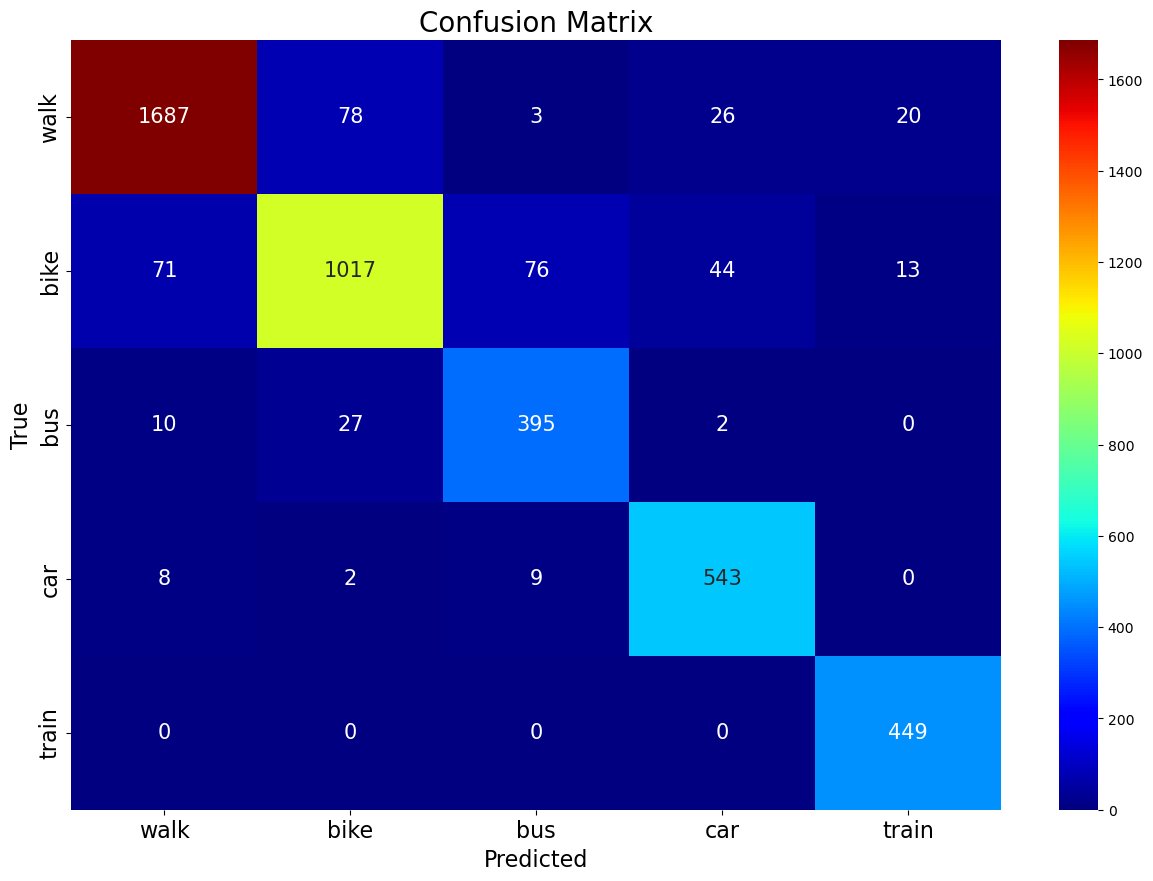

In [99]:
# Plt Confusion Matrix
LABELS = ['walk','bike', 'bus', 'car', 'train']
cm = confusion_matrix(Test_Y_N, Pred_Y_N)
# bg_color = (0.88,0.85,0.95)
# % matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(15, 10))
sn.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='jet', annot_kws={'size': 15})
plt.title('Confusion Matrix', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)

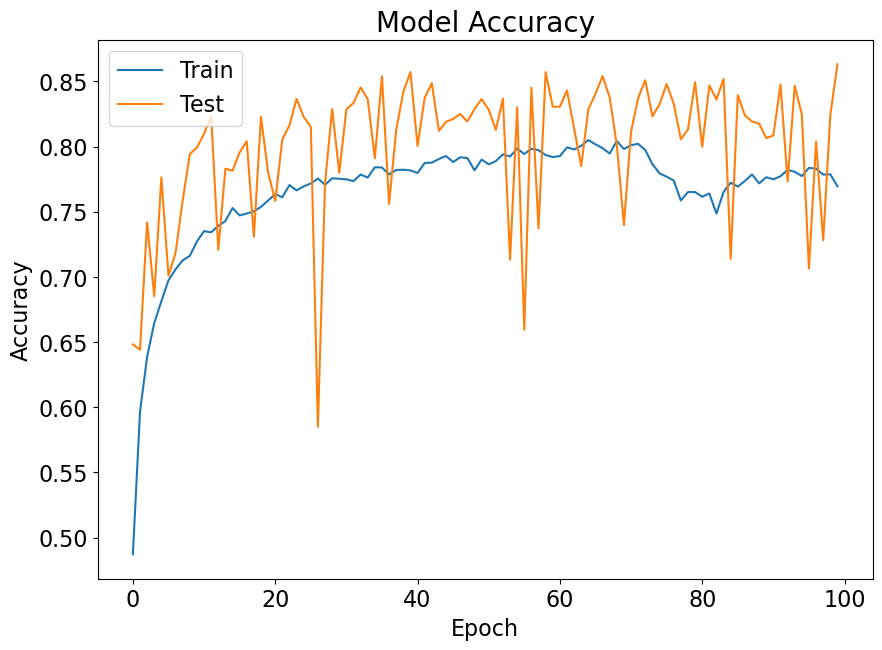

In [42]:
# Summarize History For Accuracy
plt.figure(figsize=(10, 7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=16)
plt.show()

In [ ]:
# Summarize History For Loss
plt.figure(figsize=(10, 7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper left', fontsize=16)
plt.show()